Hunter Bennett | Glass Lab | Kupffer Strains Project | 4 June 2021

This is a re-vamp of the differential peak calling pipeline for comparisons within strains in a given condition (healthy, CCl4, NASH). This pipeline takes in ATAC-seq peaks annotated with H3K27Ac ChIP-seq data (or other histone modified data) from three strains (c57, balb, and aj) and compares each strain to the other pairwise. The main outputs of this file are:
1. A homer differential peak file containing each pairwise comparison.
2. Scatterplots of each pairwise comparison with significant peaks highlighted.
3. Heatmaps of differential peaks across all comparisons to highlight patterns.
4. Peak files for GREAT analysis of functional annotations associated with genomic regions.

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [12]:
dataDirectory = '/home/h1bennet/strains/data/ATAC/control_cohort2/'
workingDirectory = '/home/h1bennet/strains_f1/results/00_CB6F1_Control_ATAC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

if not os.path.isdir('./diff_output/'):
    os.mkdir('./diff_output/')


In [4]:
balb_paths = np.sort(glob.glob(dataDirectory+'*balb*'))
c57_paths = np.sort(glob.glob(dataDirectory+'*c57bl6*'))

balb_ids = [i.split('_')[9] for i in balb_paths]
c57_ids = [i.split('_')[9] for i in c57_paths]

ids = ['balbcj_kupffer_control_young',
       'c57bl6j_kupffer_control_young']
colors = ['#377eb8',
          '#4daf4a']
paths = [';'.join(balb_paths),
         ';'.join(c57_paths)]
short_ids = [';'.join(balb_ids),
             ';'.join(c57_ids)]

pd.DataFrame([ids,colors,paths,short_ids]).T.to_csv('./sampleDefF0.txt',
                                                    sep='\t',
                                                    header=False,
                                                    index=False)

    source activate r-ouyangPipe

    mkdir ./peakQuanF0/

    mkdir ./peakDiffF0/

    nohup peakQuan.R ./sampleDefF0.txt -o ./peakQuanF0/ -g mm10 -a atac \
    -p ~/strains_f1/data/annotate_mutations_merge_f0_f1.idr \
    --homer='-size 200 -pc 0' > peakQuanF0.nohup.out

    nohup peakDiff.R ./sampleDefF0.txt -o ./peakDiffF0/ -g mm10 -a atac \
    -q ./peakQuanF0/allRawTags.txt > peakDiffF0.nohup.out


In [5]:
df, mat = read_annotated_peaks('./peakQuanF0/allRawTags.txt')

In [9]:
best_reps = ['/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB1_TDT_l20210213_TCATGAGC_CTCTCTAT_S15_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB2_TDT_l20210213_CCTGAGAT_TATCCTCT_S16_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB3_TDT_l20210213_TAGCGAGT_GTAAGGAG_S17_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB4_TDT_l20210213_GTAGCTCC_ACTGCATA_S18_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C571_TDT_l20210213_TACTACGC_AAGGAGTA_S19_L001_trim30',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C572_TDT_l20210213_AGGCTCCG_CTAAGCCT_S20_L001_trim30',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C573_TDT_l20210213_GCAGCGTA_CGTCTAAT_S21_L001_trim30',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C574_TDT_l20210213_CTGCGCAT_TCTCTCCG_S22_L001_trim30']

In [65]:
# import annotation file
df, mat = read_annotated_peaks('./peakQuanF0/allRawTags.txt')

# pull out selected samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df= df.loc[:, tst]
mat = mat.loc[:, mat.columns.str.contains('|'.join(best_reps))]

df.to_csv('./peakQuan/allRawTags_onlymuts.txt', sep='\t')


# also save version that filters based on amounts of tags
groups = [[0,1,2,3],
         [4,5,6,7]]
thresh = 4
n_passing_thresh=3

peaks = []
for group in groups:
    bool_peaks = (mat.iloc[:, group] > thresh).sum(1)>n_passing_thresh
    peaks.extend(mat.index[bool_peaks])
                  
mat_filt = mat.reindex(set(peaks)).dropna()
df_filt = df.reindex(set(peaks)).dropna()

print("N IDR Peaks:", mat.shape[0])
print("N Peaks Passing Thresh:", len(set(peaks)))
print("N Filtered Peaks:", mat_filt.shape[0])

df_filt.to_csv('./peakQuanF0/allRawTags_filtered_peaks.txt', sep='\t')

# save distal version for peak calling
df_filt_distal = df_filt.reindex(df_filt.index[np.abs(df_filt['Distance to TSS']) > 3000])
df_filt_distal.to_csv('./peakQuanF0/allRawTags_filtered_peaks_distal.txt', sep='\t')

N IDR Peaks: 137971
N Peaks Passing Thresh: 75976
N Filtered Peaks: 75976


In [15]:
%%bash

source activate deseq_36
getDiffExpression.pl ./peakQuanF0/allRawTags_filtered_peaks.txt \
balbcj_atac balbcj_atac balbcj_atac balbcj_atac \
c57bl6j_atac c57bl6j_atac c57bl6j_atac c57bl6j_atac \
-peaks > ./diff_output/diff_output_atac_f0.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats balbcj_atac vs. c57bl6j_atac:
		Total Genes: 71183
		Total Up-regulated in c57bl6j_atac vs. balbcj_atac: 2591 (3.640%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in c57bl6j_atac vs. balbcj_atac: 3455 (4.854%) [log2fold<-1, FDR<0.05]



# Filtered peaks

In [16]:
diff_peak_f1, peaks_f1, peak_mat_f1, peak_mat_quant_f1 = import_homer_diffpeak(
    './diff_output/diff_outuput_atac_f0.txt',
    './peakQuanF0/allRawTags_filtered_peaks.txt')

comp_dict = pull_comparisons_get_diff(diff_peak_f1, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (71183, 26)
getDiffExpression selected transcripts (71183, 29)
annotatePeaks selected peaks (71183, 26)


dict_keys(['balbcj_atac vs. c57bl6j_atac'])

In [20]:
comps = ['balbcj_atac vs. c57bl6j_atac']

groups = [[[0,1,2,3],[4,5,6,7]]]

cols = []
for i in groups:
    for j in i:
        cols.extend(j)
cols = [cols]

colors = [['#3182bd', '#31a354']]

pval = 0.05
log2fc = np.log2(2)

balbcj_atac vs. c57bl6j_atac
N peaks downregulated 3455
N peaks upregulated 2578



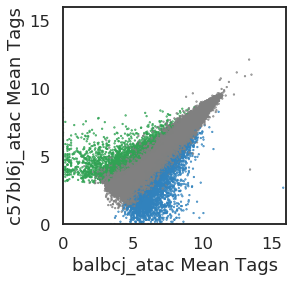

In [21]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat_f1.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat_f1.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat_f1.iloc[:, group[1]].mean(1)+1)
    de = de.reindex(de.index[(de.g0_mean >= 3) | (de.g1_mean >= 3)])

    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -log2fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > log2fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -log2fc)))
    print('N peaks upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > log2fc)))
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

make reverse plot to match F1

In [25]:
comps = ['balbcj_atac vs. c57bl6j_atac']

groups = [[[4,5,6,7], [0,1,2,3]]]

cols = []
for i in groups:
    for j in i:
        cols.extend(j)
cols = [cols]

colors = [['#3182bd', '#31a354']]

pval = 0.05
log2fc = np.log2(2)

balbcj_atac vs. c57bl6j_atac
N peaks downregulated 2578
N peaks upregulated 3455



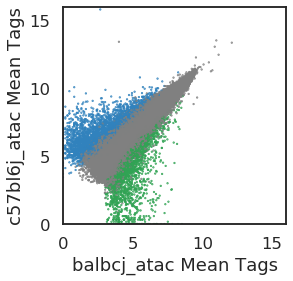

In [26]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat_f1.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat_f1.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat_f1.iloc[:, group[1]].mean(1)+1)
    de = de.reindex(de.index[(de.g0_mean >= 3) | (de.g1_mean >= 3)])

    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -log2fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > log2fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > log2fc))) #FLIPPED
    print('N peaks upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -log2fc))) #FLIPPED
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext_flipped.png', bbox_inches='tight')
    # plt.close()

# Extract target peaks

In [73]:
if not os.path.isdir('./motif_calling/'):
    os.mkdir('./motif_calling/')

In [74]:
convert_dict = {'Start': int,
                'End': int}

# set p value and log2fcs
pval = 0.05
log2fc = np.log2(2)

peak_dict = {}

# this is just c57 vs balb, c57 being coded as positive

for i in glob.glob('./diff_output/diff_output_atac_f0.txt'):
    diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
        i,
        './peakQuanF0/allRawTags_filtered_peaks.txt')
    
    # force comparison name
    strain1 = 'c57bl6j'
    strain2 = 'balbcj'
    
    # extract distal peaks only
    diff_peak_distal = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS']) >= 3000, :]
    
    # log2fc is in position -3, adj p value is in position -1
    # positive peaks are up in NASH, negative peaks are down in NASH
    balb = diff_peak.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak.iloc[:, -1] < pval), :].index.tolist()
    c57 = diff_peak.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak.iloc[:, -1] < pval), :].index.tolist()
    
    # activated peaks stored in the [0] position.
#     peak_dict['c57_vs_balb'] = [act, rep]
    
    # save to list
    # print(comp_name)
    print('n balb peaks:',diff_peak.reindex(balb).dropna(how='all').shape[0])
    diff_peak.reindex(balb).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './motif_calling/%s_log2fc_%.1f_pval_%.2f.txt' % ('balbcj', log2fc, pval),
    sep='\t')
    
    print('n distal balb peaks:',diff_peak_distal.reindex(balb).dropna(how='all').shape[0])
    diff_peak_distal.reindex(balb).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './motif_calling/%s_distal_log2fc_%.1f_pval_%.2f.txt' % ('balbcj', log2fc, pval),
    sep='\t')
    
    print('n c57 peaks:',diff_peak.reindex(c57).dropna(how='all').shape[0])
    diff_peak.reindex(c57).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './motif_calling/%s_log2fc_%.1f_pval_%.2f.txt' % ('c57bl6j', log2fc, pval),
    sep='\t')
    
    print('n distal c57 peaks:',diff_peak_distal.reindex(c57).dropna(how='all').shape[0])
    diff_peak_distal.reindex(c57).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './motif_calling/%s_distal_log2fc_%.1f_pval_%.2f.txt' % ('c57bl6j', log2fc, pval),
    sep='\t')

annotatePeaks all peaks (71183, 26)
getDiffExpression selected transcripts (71183, 29)
annotatePeaks selected peaks (71183, 26)
n balb peaks: 3455
n distal balb peaks: 2992
n c57 peaks: 2591
n distal c57 peaks: 2049


In [75]:
strain_dict = {'c57bl6j': 'c57bl6j',
               'balbcj': 'balbcj',
               'aj': 'aj'}

# background set all peaks that were considered as differential
all_peaks = './peakQuanF0/allRawTags_filtered_peaks.txt' 
all_peaks_distal = './peakQuanF0/allRawTags_filtered_peaks_distal.txt'

with open('./findMotifs_differential.sh', 'w') as f:
    for peakfile in np.sort(glob.glob('./motif_calling/*log2fc*.txt')):
        strain = peakfile.split('/')[-1].split('_')[0]
        if 'distal' in peakfile:
            call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                    peakfile, 'mm10', peakfile.replace('.txt', '_motifs'),
                    '-bg', all_peaks_distal,
                    '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                    '-bg_strain', strain_dict[strain], '-p 8\n\n']
        else:
            call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                    peakfile, 'mm10', peakfile.replace('.txt', '_motifs'),
                    '-bg', all_peaks,
                    '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                    '-bg_strain', strain_dict[strain], '-p 8\n\n']
        f.write(' '.join(call))

In [76]:
!cat ./findMotifs_differential.sh

/home/vlink/code/marge/bin/MMARGE.pl denovo_motifs ./motif_calling/balbcj_distal_log2fc_1.0_pval_0.05.txt mm10 ./motif_calling/balbcj_distal_log2fc_1.0_pval_0.05_motifs -bg ./peakQuanF0/allRawTags_filtered_peaks_distal.txt -len 8,10,12,14,16 -fg_strain balbcj -bg_strain balbcj -p 8

/home/vlink/code/marge/bin/MMARGE.pl denovo_motifs ./motif_calling/balbcj_log2fc_1.0_pval_0.05.txt mm10 ./motif_calling/balbcj_log2fc_1.0_pval_0.05_motifs -bg ./peakQuanF0/allRawTags_filtered_peaks.txt -len 8,10,12,14,16 -fg_strain balbcj -bg_strain balbcj -p 8

/home/vlink/code/marge/bin/MMARGE.pl denovo_motifs ./motif_calling/c57bl6j_distal_log2fc_1.0_pval_0.05.txt mm10 ./motif_calling/c57bl6j_distal_log2fc_1.0_pval_0.05_motifs -bg ./peakQuanF0/allRawTags_filtered_peaks_distal.txt -len 8,10,12,14,16 -fg_strain c57bl6j -bg_strain c57bl6j -p 8

/home/vlink/code/marge/bin/MMARGE.pl denovo_motifs ./motif_calling/c57bl6j_log2fc_1.0_pval_0.05.txt mm10 ./motif_calling/c57bl6j_log2fc_1.0_pval_0.05_motifs -bg ./pe

# Investigate peaks manually

In [44]:
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [45]:
diff_peak.to_csv('./diff_output/diff_output_atac_f0_filtered_peaks_with_location.txt',
                 sep='\t')

In [46]:
diff_peak.columns

Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Distance to TSS', 'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene',
       'Nearest Refseq', 'Nearest Ensembl', 'Gene Name', 'Gene Alias',
       'Gene Description', 'Gene Type',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB1_TDT_l20210213_TCATGAGC_CTCTCTAT_S15_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB2_TDT_l20210213_CCTGAGAT_TATCCTCT_S16_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB3_TDT_l20210213_TAGCGAGT_GTAAGGAG_S17_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BAL

In [47]:
viz_cols = ['Annotation', 'Distance to TSS', 'Gene Name', 'location', 'Annotation',
            'balbcj_atac vs. c57bl6j_atac Log2 Fold Change',
            'balbcj_atac vs. c57bl6j_atac adj. p-value']
diff_peak_viz = diff_peak.loc[:, viz_cols]

In [50]:
diff_peak_viz.sort_values(
    'balbcj_atac vs. c57bl6j_atac adj. p-value', ascending=True).head(20)

,Annotation,Distance to TSS,Gene Name,location,Annotation,balbcj_atac vs. c57bl6j_atac Log2 Fold Change,balbcj_atac vs. c57bl6j_atac adj. p-value
PeakID,,,,,,,
Merged-chr10-85386728-3,promoter-TSS (NM_028709),-105.0,Btbd11,chr10:85386609-85386809,promoter-TSS (NM_028709),5.467821,2.451012e-71
Merged-chr17-71483959-3,Intergenic,-8615.0,Smchd1,chr17:71483858-71484058,Intergenic,6.446630,1.324710e-61
Merged-chr16-45644661-3,"intron (NM_145389, intron 2 of 5)",9451.0,BC016579,chr16:45644567-45644767,"intron (NM_145389, intron 2 of 5)",7.120576,1.802346e-56
Merged-chr8-127441329-4,"intron (NM_033620, intron 20 of 24)",141692.0,Pard3,chr8:127441244-127441444,"intron (NM_033620, intron 20 of 24)",3.266613,3.658370e-47
Merged-chr4-119177928-3,"3' UTR (NM_013848, exon 13 of 13)",-3720.0,Zfp691,chr4:119177815-119178015,"3' UTR (NM_013848, exon 13 of 13)",5.374169,2.496601e-46
Merged-chr4-6222229-4,Intergenic,31132.0,Ubxn2b,chr4:6222137-6222337,Intergenic,3.888232,1.260629e-45
Merged-chr6-134556398-3,"intron (NM_008514, intron 1 of 22)",10532.0,Lrp6,chr6:134556281-134556481,"intron (NM_008514, intron 1 of 22)",6.179798,1.260629e-45
Merged-chr1-52307216-3,Intergenic,-73967.0,Gls,chr1:52307099-52307299,Intergenic,-4.280392,7.917131e-45
Merged-chr16-45657804-3,"intron (NM_172455, intron 17 of 17)",-3662.0,BC016579,chr16:45657680-45657880,"intron (NM_172455, intron 17 of 17)",4.371552,2.993267e-44
